In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from config import gkey
import gmaps
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt

In [3]:
analysisdata = pd.read_csv("analysisdata.csv")[["Country","2016","Disaster rate","Internet Access Rate"]]
analysisOECDdata = pd.read_csv("analysisOECDdata.csv")[["Country","2016","Disaster rate","Internet Access Rate","Average Sleeping (Hours)"]]
location= pd.read_csv("../Xuan Code/country-capitals.csv")[["CountryName","CapitalLatitude","CapitalLongitude"]]
location.columns=[["Country","Lat","Lng"]]
location.to_csv("coordinate.csv")
newlocation = pd.read_csv("coordinate.csv")[["Country","Lat","Lng"]]
analysisdata.loc[analysisdata["Country"]=="United States","Country"]= "United States of America"
analysisdata_location = pd.merge(analysisdata,newlocation,on = "Country")


In [4]:
gmaps.configure(api_key = gkey)
locations = analysisdata_location[["Lat","Lng"]]
happiness = analysisdata_location["2016"]
internet = analysisdata_location["Internet Access Rate"]
disaster = analysisdata_location["Disaster rate"]
country = analysisdata_location["Country"] 

In [5]:
fig = gmaps.figure()
heat_layer = gmaps.heatmap_layer(locations, weights=happiness, 
                                 dissipating=False, max_intensity=50,
                                 point_radius = 3)
happiness_layer = gmaps.symbol_layer(locations, fill_color='rgba(0, 150, 0, 0.4)',
                                    stroke_color='rgba(0, 0, 150, 0.4)', scale=2,
                                    info_box_content=[f"Happiness Score: {score}" for score in happiness])
fig.add_layer(heat_layer)
fig.add_layer(happiness_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [6]:
from matplotlib.cm import jet
from matplotlib.colors import to_hex

In [7]:
from matplotlib.colors import LinearSegmentedColormap
def grayscale_cmap(cmap):
    """Return a grayscale version of the given colormap"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    # convert RGBA to perceived grayscale luminance
    # cf. http://alienryderflex.com/hsp.html
    RGB_weight = [0.299, 0.587, 0.114]
    luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
    colors[:, :3] = luminance[:, np.newaxis]
    return LinearSegmentedColormap.from_list(cmap.name + "_gray", colors, cmap.N)
    

In [9]:
import gmaps
import gmaps.geojson_geometries
gmaps.configure(api_key=gkey)
countries_geojson = gmaps.geojson_geometries.load_geometry("countries")

from matplotlib.cm import viridis
from matplotlib.colors import to_hex

# We will need to scale the GINI values to lie between 0 and 1
min_gini = min(internet)
max_gini = max(internet)
gini_range = max_gini - min_gini

def calculate_color(gini):
    """
    Convert the GINI coefficient to a color
    """
    # make gini a number between 0 and 1
    normalized_gini = (gini - min_gini) / gini_range

    # invert gini so that high inequality gives dark color
    inverse_gini = 1.0 - normalized_gini

    # transform the gini coefficient to a matplotlib color
    mpl_color = jet(inverse_gini)

    # transform from a matplotlib color to a valid CSS color
    gmaps_color = to_hex(mpl_color, keep_alpha=False)

    return gmaps_color

def view_colormap(cmap):
    """Plot a colormap with its grayscale equivalent"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    #cmap = grayscale_cmap(cmap)
    #grayscale = cmap(np.arange(cmap.N))
    
    fig, ax = plt.subplots(figsize=(12, 1))#,subplot_kw=dict(xticks=[], yticks=[]))
    ax.imshow([colors], extent=[max_gini*10, min_gini*10, 0, 1])
    #ax[1].imshow([grayscale], extent=[0, 10, 0, 1])

In [10]:
internet_country = analysisdata_location[["Country","Internet Access Rate"]].set_index("Country")
colors = []
for feature in countries_geojson['features']:
    country_name = feature['properties']['name']
    try:
        gini = internet_country.loc[country_name,"Internet Access Rate"]
        color = calculate_color(gini)
    except KeyError:
        # no GINI for that country: return default color
        color = (0, 0, 0, 0.3)
    colors.append(color)

Figure(layout=FigureLayout(height='420px'))

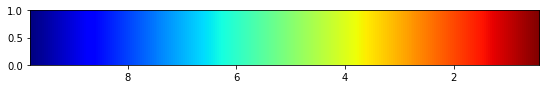

In [11]:
fig = gmaps.figure()
gini_layer = gmaps.geojson_layer(
countries_geojson,
fill_color=colors,
stroke_color=colors,
fill_opacity=0.8)
fig.add_layer(gini_layer)
view_colormap(jet)
fig
